# Домашнее задание "Бинарная классификация изображений и решение проблемы дисбаланса классов"

## Введение
В этом домашнем задании вы будете работать с задачей бинарной классификации изображений. Мы будем использовать датасет "Cats vs Dogs", чтобы создать модель, способную различать изображения кошек и собак. Тренировочный набор данных содержит 10 000 изображений кошек и 10 000 изображений собак. В тестовом наборе содержится по 2 500 картинок каждого класса.

Цель домашнего задания — закрепить знания о том, как загружать и предобрабатывать данные, определять и обучать нейронные сети, оценивать их эффективность и визуализировать результаты.

## Импорт необходимых библиотек
Для решения поставленной задачи вам понадобятся библиотеки для работы с числовыми данными, обучения нейронных сетей и отрисовки графиков. В этой части кода импортируйте необходимые библиотеки, установите seed для воспроизводимости результатов и определите устройство для работы — cpu или cuda.

In [1]:
# Библиотека для работы с числами и матрицами
import numpy as np

# Библиотека для генерации псевдослучайных чисел
import random

# Библиотеки для работы с нейронными сетями
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms, datasets, models

# Библиотека для визуализации данных
import matplotlib.pyplot as plt

In [2]:
# Установка seed для воспроизводимости результатов
seed = 0

# Задаем seed для генераторов псевдослучайных чисел в Python, PyTorch и NumPy
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Если доступна CUDA, задаём seed для GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Устанавливаем поведение CuDNN в детерминированный режим
torch.backends.cudnn.deterministic = True
# Включаем режим оптимизации CuDNN
torch.backends.cudnn.benchmark = True

# Создаем генератор случайных чисел PyTorch и задаем ему seed
g = torch.Generator()
g.manual_seed(seed)

# Функция для установки seed в DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Задание №1: Загрузка и предобработка данных
Теперь вам необходимо выполнить загрузку и предобработку данных. В качестве бейзлайна можете использовать следующие аугментации (обязательно поэкспериментируйте с другими!):
- изменение размера изображения до 224х224;
- случайное горизонтальное отражение;
- случайное изменение яркости, контраста, насыщенности и оттенка;
- преобразование в тензор.

Для тестового набора данных используйте только изменение размера до 224х224 и преобразование в тензор.

In [4]:
# Преобразования для обучающего набора данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение цвета
    transforms.ToTensor()  # Преобразование в тензор
])

# Преобразования для тестового набора данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.ToTensor()  # Преобразование в тензор
])

Датасет для скачивания вы можете найти по [ссылке](https://www.kaggle.com/datasets/salader/dogs-vs-cats?select=test). После скачивания откройте Google Drive (Google Диск) и загрузите архив в удобную для вас директорию.

In [5]:
# Подключение Google Диска
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Разархивирование скачанного архива (при необходимости замените пути)
#!unzip -q dogs-vs-cats.zip "train/*" "test/*" -d dogs_vs_cats

Убедитесь, что в разделе `Файлы` у вас появилась папка следующего вида:
```
dogs_vs_cats/
├── train/
│   ├── cats/
│   └── dogs/
└── test/
    ├── cats/
    └── dogs/
```
После этого можно перейти к формированию датасета. При работе с данными такой структуры применяется функция `ImageFolder` из `torchvision.datasets`. Примените заданные трансформы. При необходимости измените пути к данным.

In [7]:
# Загрузка обучающего набора данных
train_data = torchvision.datasets.ImageFolder(root='dogs_vs_cats/train/', transform=train_transform)
test_data = torchvision.datasets.ImageFolder(root='dogs_vs_cats/test/', transform=test_transform)

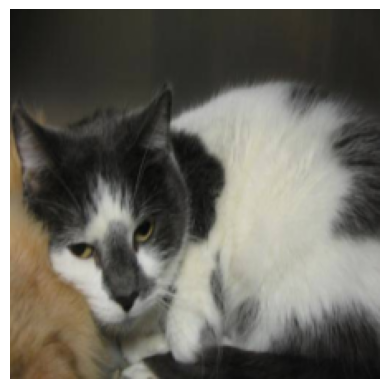

In [8]:
plt.imshow(np.transpose(test_data[102][0].numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

## Создание несбалансированной выборки

Для усложнения задачи создадим несбалансированную версию датасета. В качестве редуцируемого класса выберем "cats".

In [9]:
# import os
# import random
# from torchvision import datasets
# from torch.utils.data import Subset

# def create_imbalanced_dataset(dataset, percentage=0.1):
#     # Разделим индексы по классам
#     cats_indices = [i for i, (_, label) in enumerate(dataset) if dataset.classes[label] == 'cats']
#     dogs_indices = [i for i, (_, label) in enumerate(dataset) if dataset.classes[label] == 'dogs']
#     # Выберем 10% от класса 'cats'
#     selected_cats_indices = random.sample(cats_indices, int(len(cats_indices) * percentage))
#     final_indices = selected_cats_indices + dogs_indices

#     return Subset(dataset, final_indices)

In [10]:
import random
from torchvision import datasets
from torch.utils.data import Subset
def create_imbalanced_dataset(dataset, percentage=0.1):
    # Разделим индексы по классам
    targets = np.array(train_data.targets)
    cats_indices = list(np.where(targets == 0)[0])
    dogs_indices = list(np.where(targets == 1)[0])
    # Выберем 10% от класса 'cats'
    selected_cats_indices = random.sample(cats_indices, int(len(cats_indices) * percentage))
    final_indices = selected_cats_indices + dogs_indices

    return Subset(dataset, final_indices)

In [11]:
# Создание несбалансированного датасета (10% класса 'cats')
imbalanced_train_data = create_imbalanced_dataset(train_data, percentage=0.1)

Теперь создайте загрузчики данных (DataLoader) для тренировочного и тестового наборов данных.  
Не забудьте про перемешивание обучающего набора данных перед каждой эпохой. Также задайте параметры *worker_init_fn* и *generator* для воспроизводимости.

In [12]:
imbalanced_train_loader = DataLoader(imbalanced_train_data, batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g)

## Задание №2: Обучение модели на несбалансированных данных
Выберите модель и обучите ее на несбалансированных данных. Вы можете взять функцию для обучения из семинара, а лучше напишите свою. Не забывайте сохранять веса обученных моделей.

После обучения модели посмотрите отчет о классификации и матрицу ошибок, используя `classification_report` и `confusion_matrix` из `sklearn.metrics`. Что можно сказать о полученных метриках?

In [13]:
from torchvision.models import efficientnet_b0
from tqdm.notebook import tqdm

In [14]:
def train(model, train_loader, criterion, optimizer):
    
    model.train()
    
    total_loss, correct, total = 0, 0, 0
    
    for images, labels in tqdm(train_loader, desc="train"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()


        total_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = total_loss / total
    train_acc = correct / total
    return train_acc, train_loss

In [15]:
def inference(model, val_loader, criterion=None, log=False):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_arr, labels_arr = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="val"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            if criterion:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)
            
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            
            total += labels.size(0)
            
            if log:
                preds_arr.append(preds)
                labels_arr.append(labels)
    if criterion:           
        val_loss = total_loss / total
    else:
        val_loss = None
    val_acc = correct / total
    
    if log:
        return val_acc, val_loss, \
               torch.cat(preds_arr).ravel().cpu().numpy(), \
               torch.cat(labels_arr).ravel().cpu().numpy()
    return val_acc, val_loss

In [16]:
def run_exp(model, train_loader, val_loader, criterion, optimizer, exp_name, epochs=10, return_arrays=False):
    
    best_acc = 0.0
    os.makedirs('checkpoints', exist_ok=True)
    train_acc_arr = []
    train_loss_arr = []
    val_acc_arr = []
    val_loss_arr = []
    for epoch in range(epochs):
        
        train_acc, train_loss = train(model, train_loader, criterion, optimizer)
        val_acc, val_loss = inference(model, val_loader, criterion)
        
        if return_arrays:
            train_acc_arr.append(train_acc)
            train_loss_arr.append(train_loss)
            val_acc_arr.append(val_acc)
            val_loss_arr.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Loss={val_loss:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(f"checkpoints/{exp_name}.pth"))
            print("Checkpoint saved!")
    if return_arrays:
        return train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr

In [45]:
model = efficientnet_b0(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [46]:
c = 0
for p in model.parameters():
    c += p.numel()
print(c)

4010110


In [47]:
train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = run_exp(model, imbalanced_train_loader, test_loader, criterion, optimizer, "baseline", epochs=3, return_arrays=True)

train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/3: Train Loss=0.7946, Train Acc=0.8695, Val Acc=0.4998, Val Loss=2.3280
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/3: Train Loss=0.4087, Train Acc=0.9031, Val Acc=0.5000, Val Loss=2.2620
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/3: Train Loss=0.3845, Train Acc=0.9055, Val Acc=0.5000, Val Loss=2.1125


In [33]:
def print_plots(train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr):
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(train_acc_arr, label='train')
    ax[0].plot(val_acc_arr, label='val')
    ax[0].grid()
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_title('Accuracy')
    ax[0].set_xticks(np.arange(len(train_acc_arr)))
    
    ax[1].plot(train_loss_arr, label='train')
    ax[1].plot(val_loss_arr, label='val')
    
    ax[1].grid()
    ax[1].legend()
    ax[1].set_xlabel('epochs')
    ax[1].set_title('Loss')
    ax[1].set_xticks(np.arange(len(train_acc_arr)))
    
    plt.show()

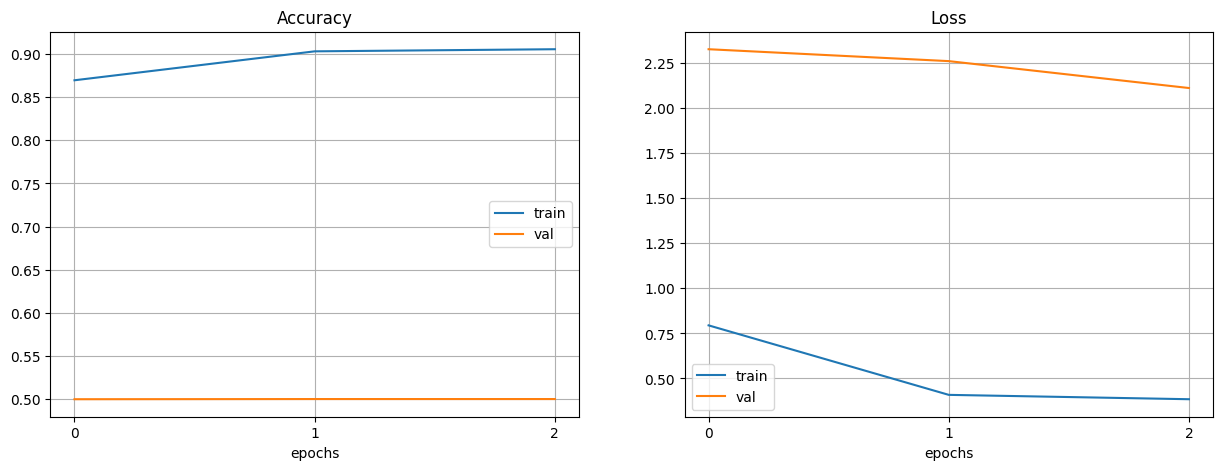

In [78]:
print_plots(train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [35]:
def run_and_metrics(model, checkpoint, val_loader, if_return=False):
    sd = torch.load(checkpoint, weights_only=True)
    model.load_state_dict(sd)
    val_acc, _, y_pred, y_true = inference(model, val_loader, log=True)
    print(classification_report(y_true, y_pred, target_names=[test_data.classes[0], test_data.classes[1]], zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=test_data.classes)
    disp.plot()
    plt.show()
    if if_return:
        return y_pred, y_true

val:   0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        cats       0.00      0.00      0.00      2500
        dogs       0.50      1.00      0.67      2500

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.33      5000
weighted avg       0.25      0.50      0.33      5000



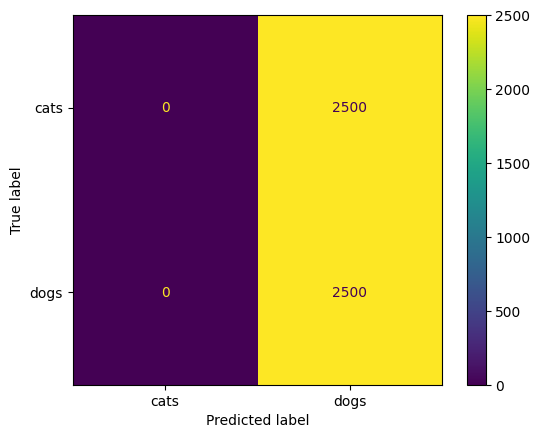

In [61]:
run_and_metrics(model, 'checkpoints/baseline.pth', test_loader)

<div class="alert alert-block alert-info">
Модель константно предсказывает мажорижующий класс, потому что с точки зрения кросс-энтропии это наилучший вариант. 
</div>

## Решение проблемы дисбаланса классов
Чтобы модель могла лучше предсказывать малопредставленные классы, необходимо использовать специальные методы, для адаптации процесса обучения. Рассмотрим такие подходы.


## Задание №3: Resampling
Resampling включает в себя ве техники — **under**sampling и **over**sampling.

**Undersampling** — это метод, направленный на борьбу с дисбалансом классов, при котором количество объектов в более часто встречающихся классах уменьшается, чтобы выровнять количество объектов в каждом классе.
Этот подход эффективен, когда объем данных велик, и удаление части данных не приведет к значительной потере информации. Его основное преимущество — это сокращение времени и ресурсов, необходимых для обучения модели. Однако минус заключается в том, что важная информация может быть потеряна, если вместе с избыточными данными удаляются редкие события или аномалии.

**Oversampling**, наоборот, увеличивает количество примеров в менее представленном классе за счет дублирования существующих примеров или генерации новых синтетических данных.
Этот метод сохраняет всю информацию исходного набора данных, увеличивая вероятность того, что модель научится распознавать менее частые классы.

![resampling](https://blog.strands.com/hs-fs/hubfs/Screenshot%202019-07-18%20at%2014.15.15.png?width=1800&name=Screenshot%202019-07-18%20at%2014.15.15.png)

Реализуйте оба метода, используя `WeightedRandomSampler` из `torch.utils.data`. Вычислите веса для классов на основе обратной частоты их появления. Передайте список весов для каждого элемента в наборе данных в качестве аргумента `WeightedRandomSampler`. Полученный семплер используйте при создании DataLoader.

### Undersampling

In [ ]:
# YOUR CODE HERE

### Oversampling

In [17]:
from collections import Counter

In [18]:
labels = [label for _, label in imbalanced_train_data]


In [19]:
class_counts = torch.bincount(torch.tensor(labels))
print("Class counts:", class_counts)

Class counts: tensor([ 1000, 10000])


In [20]:
class_weights = 1. / class_counts.float()

In [21]:
sample_weights = class_weights[labels]

In [22]:
class_weights

tensor([1.0000e-03, 1.0000e-04])

In [85]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(labels), replacement=True)

In [86]:
balanced_train_loader = DataLoader(imbalanced_train_data, 
                                     batch_size=64, 
                                     worker_init_fn=seed_worker, 
                                     generator=g, 
                                     sampler=sampler)

In [88]:
model = efficientnet_b0(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = run_exp(model, balanced_train_loader, test_loader, criterion, optimizer, "sampler", epochs=10, return_arrays=True)

train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=1.5130, Train Acc=0.5375, Val Acc=0.6206, Val Loss=1.3401
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10: Train Loss=0.9170, Train Acc=0.5981, Val Acc=0.5956, Val Loss=1.1019


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10: Train Loss=0.8884, Train Acc=0.5485, Val Acc=0.5748, Val Loss=0.7158


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10: Train Loss=0.7717, Train Acc=0.5884, Val Acc=0.6318, Val Loss=0.6420
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10: Train Loss=0.6995, Train Acc=0.6429, Val Acc=0.6568, Val Loss=0.6322
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10: Train Loss=0.6475, Train Acc=0.6708, Val Acc=0.6860, Val Loss=0.5962
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10: Train Loss=0.6131, Train Acc=0.7098, Val Acc=0.7050, Val Loss=0.5763
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10: Train Loss=0.5739, Train Acc=0.7285, Val Acc=0.7198, Val Loss=0.5539
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10: Train Loss=0.5371, Train Acc=0.7442, Val Acc=0.7570, Val Loss=0.5010
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.5128, Train Acc=0.7544, Val Acc=0.7706, Val Loss=0.4777
Checkpoint saved!


Сравните метрики с теми, что были получены при первоначальнои обучении. Удалось ли повысить качество модели?

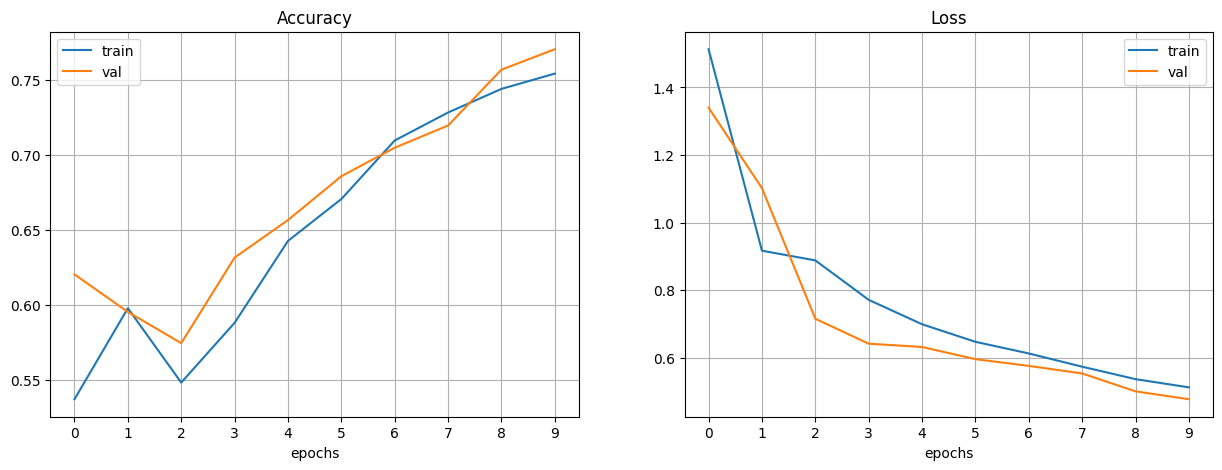

In [89]:
print_plots(train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr)

val:   0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        cats       0.76      0.79      0.78      2500
        dogs       0.78      0.75      0.77      2500

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



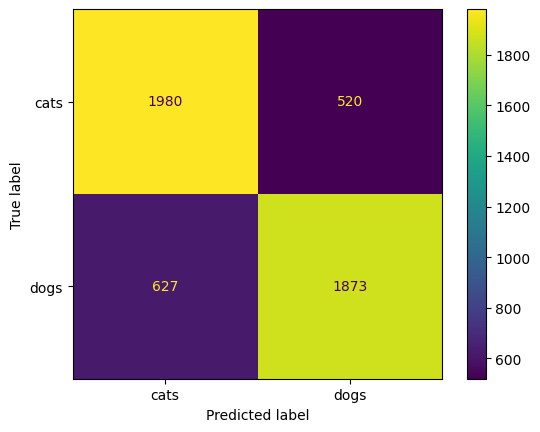

In [90]:
run_and_metrics(model, 'checkpoints/sampler.pth', test_loader)

<div class="alert alert-block alert-info">
Это уже другое дело :) Модели удалось достичь 0.77 accuracy, что намного лучше, чем 0.5 ранее. 
</div>

## Задание №4: Взвешивание классов
Другой подход, используемый при дисбалансе — взвешивание классов. Этот метод позволяет уменьшить предвзятость модели к более представленным классам, назначая больший вес ошибкам на менее представленных классах. Веса классов обычно вычисляются на основе обратной зависимости от частоты классов в данных. Полученные веса используются в качестве аргмента функции потерь.

Взвесьте классы согласно этой формуле:
$$ w_i = \frac{1}{n_i} $$
где:  
$w_i$ — вес для $i$-го класса;  
$n_i$ — число объектов $i$-го класса.

Полученые веса передайте в качестве аргумента функции потерь и запустите обучение.

In [97]:
model = efficientnet_b0(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = run_exp(model, imbalanced_train_loader, test_loader, criterion, optimizer, "weight_loss", epochs=10, return_arrays=True)

train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=1.6328, Train Acc=0.5445, Val Acc=0.6008, Val Loss=0.9523
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10: Train Loss=0.9597, Train Acc=0.5578, Val Acc=0.6088, Val Loss=0.6580
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10: Train Loss=0.8413, Train Acc=0.5748, Val Acc=0.6316, Val Loss=0.8710
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10: Train Loss=0.7186, Train Acc=0.6322, Val Acc=0.6458, Val Loss=0.8617
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10: Train Loss=0.8130, Train Acc=0.6192, Val Acc=0.6468, Val Loss=0.6795
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10: Train Loss=0.7367, Train Acc=0.6139, Val Acc=0.5940, Val Loss=0.8237


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10: Train Loss=0.7471, Train Acc=0.6473, Val Acc=0.6488, Val Loss=0.7405
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10: Train Loss=0.7150, Train Acc=0.6454, Val Acc=0.5926, Val Loss=0.6764


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10: Train Loss=0.6717, Train Acc=0.6432, Val Acc=0.6754, Val Loss=0.6287
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.6642, Train Acc=0.6362, Val Acc=0.6246, Val Loss=0.6646


Снова проверьте метрики на тестовом наборе данных.

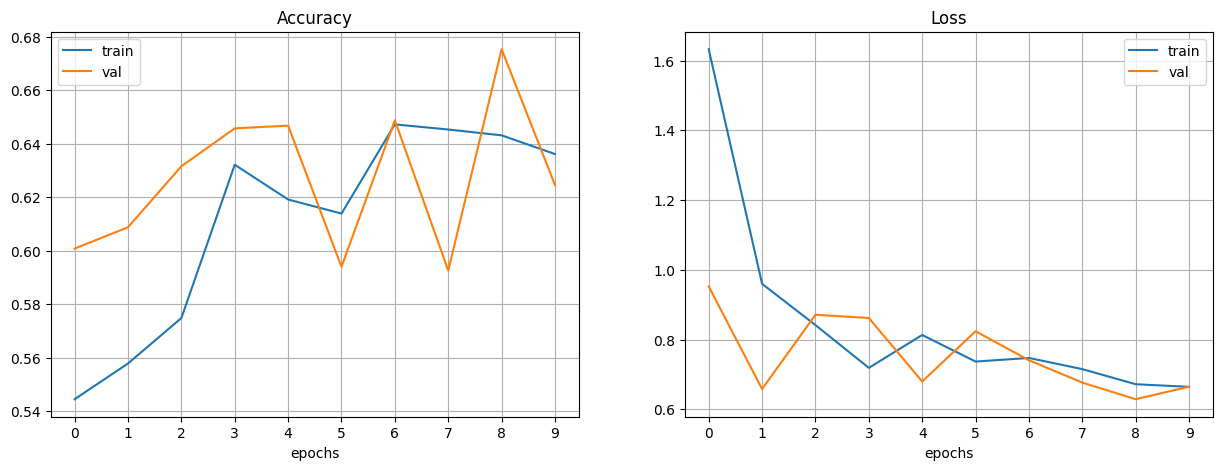

In [98]:
print_plots(train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr)

val:   0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        cats       0.67      0.70      0.68      2500
        dogs       0.68      0.65      0.67      2500

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



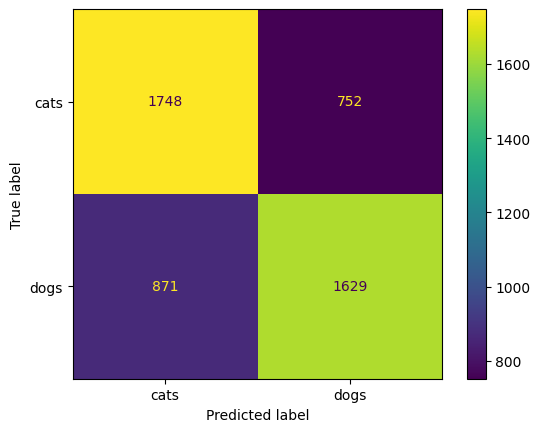

In [99]:
run_and_metrics(model, 'checkpoints/weight_loss.pth', test_loader)

## Задание №5: Focal Loss
Focal Loss — это функция потерь, используемая в задачах классификации для решения проблемы несбалансированных классов. Focal Loss модифицирует стандартную кросс-энтропийную потерю так, чтобы уменьшить влияние легко классифицируемых объектов на обучение модели и увеличить влияние "сложных", мало представленных объектов.
$$ FL(p_t) = -\sum_{c=1}^C \alpha_c (1 - p_{t,c})^\gamma \log(p_{t,c}) $$
где:  
$p_t$ — вероятность принадлежности к целевому классу;  
$\alpha_c$ — весовой коэффициент для класса $c$;  
$\gamma$ — параметр, регулирующий степень уменьшения веса легко классифицируемых объектов.

Случай $\gamma=0$ соотвествует кросс-энтропийной функции потерь. Значение параметра $\gamma>0$ уменьшает относительные потери для хорошо классифицированных объектов (верно предсказанных с высокой вероятностью), уделяя больше внимания сложным, неправильно классифицированным объектам.

![focal_loss](https://i2.wp.com/miro.medium.com/1*zvntw5mnlWLR7zUMKCS_AA.png)

Реализуйте функцию Focal Loss и задайте ее в качестве функции потерь при обучении модели.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss implementation
        :param alpha: Tensor of shape (C,) for class-wise weighting or a scalar for uniform weighting
        :param gamma: Focusing parameter, default is 2.0
        :param reduction: 'none', 'mean' (default), or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        """
        :param inputs: Logits tensor of shape (N, C)
        :param targets: Ground truth tensor of shape (N,)
        """
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Compute pt (model confidence on true class)
        pt = torch.exp(-CE_loss)
        
        # Apply the focal adjustment
        loss = self.alpha[targets] * (1 - pt) ** self.gamma * CE_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # No reduction

In [30]:
import os

In [31]:
model = efficientnet_b0(num_classes=2).to(device)
criterion = FocalLoss(alpha=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = run_exp(model, imbalanced_train_loader, test_loader, criterion, optimizer, "focal_loss", epochs=10, return_arrays=True)

train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10: Train Loss=0.0002, Train Acc=0.5201, Val Acc=0.6166, Val Loss=0.0017
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10: Train Loss=0.0001, Train Acc=0.5118, Val Acc=0.5086, Val Loss=0.0001


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10: Train Loss=0.0001, Train Acc=0.5184, Val Acc=0.6094, Val Loss=0.0001


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10: Train Loss=0.0001, Train Acc=0.5678, Val Acc=0.6036, Val Loss=0.0001


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10: Train Loss=0.0000, Train Acc=0.5862, Val Acc=0.5794, Val Loss=0.0001


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10: Train Loss=0.0001, Train Acc=0.5496, Val Acc=0.6182, Val Loss=0.0001
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10: Train Loss=0.0000, Train Acc=0.5679, Val Acc=0.5564, Val Loss=0.0001


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10: Train Loss=0.0000, Train Acc=0.6073, Val Acc=0.6272, Val Loss=0.0001
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10: Train Loss=0.0000, Train Acc=0.6188, Val Acc=0.6286, Val Loss=0.0001
Checkpoint saved!


train:   0%|          | 0/172 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.0000, Train Acc=0.5977, Val Acc=0.6510, Val Loss=0.0001
Checkpoint saved!


Посчитайте метрики на тестовом наборе данных. Какой из подходов дал наилучший результат?

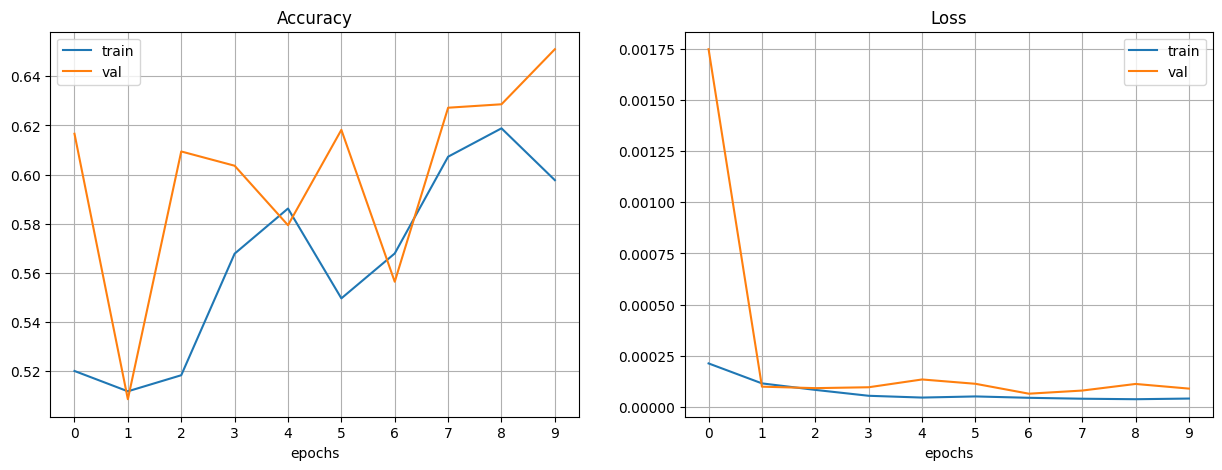

In [36]:
print_plots(train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr)

val:   0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        cats       0.61      0.82      0.70      2500
        dogs       0.73      0.48      0.58      2500

    accuracy                           0.65      5000
   macro avg       0.67      0.65      0.64      5000
weighted avg       0.67      0.65      0.64      5000



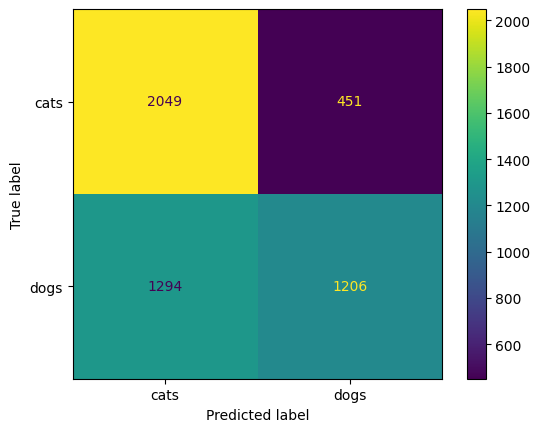

In [37]:
run_and_metrics(model, 'checkpoints/focal_loss.pth', test_loader)

## Задание №6: Выбор лучшей модели и получение предсказаний
Выберите лучшую модель и сделайте предсказания на тестовом наборе данных. Визуализируйте полученные результаты.

## Заключение
В этом домашнем задании вы закрепили знания по подготвке данных и обучению нейронных сетей, а также научились решать проблему несбалансированного датасета.
Полученные знания и навыки позволят вам успешно решать задачи классификации изображений.